In [3]:
# ====== 1. Import Library ======
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

import joblib  # untuk save model (opsional)


In [4]:
# ====== 2. Load Dataset ======

PROJECT_ROOT = Path.cwd().parent  # kalau notebook ada di root project
DATA_PATH = PROJECT_ROOT / "data" / "videos_with_genre.csv"

print("Project root:", PROJECT_ROOT)
print("Data path:", DATA_PATH)

df = pd.read_csv(DATA_PATH)
df.head()


Project root: c:\Aldy-Kuliah\Semester 7\mlOps\project\Eksperimen_SML_Aldy-Naufal
Data path: c:\Aldy-Kuliah\Semester 7\mlOps\project\Eksperimen_SML_Aldy-Naufal\data\videos_with_genre.csv


,video_id,title,description,tags,channel_id,channel_title,published_at,view_count,like_count,comment_count,duration,genres_list,primary_genre
0,zo7i8VTpfNM,"Would You Risk Dying For $500,000?",i cant believe he did that at the end\nJack Li...,NaN,UCX6OQ3DkcsbYNE6H8uQQuVA,MrBeast,2025-09-27T16:00:04Z,99413077,2090335,29439,PT25M26S,[],NaN
1,Yqq5UbDVTWI,"If You Dig It, You Keep It!","If you find the expensive item in the sand, yo...",Ben Azelart|Stay Wild|Stay Wild Vlogs|Cam Huff...,UClQ3NafOy_42dJ0toK3QUKw,Stay Wild,2025-10-19T16:32:39Z,23803195,327244,12310,PT43M50S,['Battle Royale'],Battle Royale
2,9OHRtUHezTk,"$10,000 Every Boss You Beat",The new Feastables Hazelnut Cups are now avail...,NaN,UCIPPMRA040LQr5QPyJEbmXA,MrBeast Gaming,2025-08-23T16:00:22Z,20400555,351311,4825,PT26M43S,['Sandbox'],Sandbox
3,xwfJ2TalgpM,"Clean The Sports Car, Keep It!",We competed in a satisfying sports car cleanin...,Ben Azelart|Stay Wild|Stay Wild Vlogs|Cam Huff...,UClQ3NafOy_42dJ0toK3QUKw,Stay Wild,2025-11-09T16:57:04Z,9163585,100076,4667,PT32M6S,['Battle Royale'],Battle Royale
4,mpyk0XKUCo8,ASMR Keyboard Clicky VS Keyboard Madu! [Roblox...,Jangan lupa subscribe channel utamaku Fanny Tj...,roblox|roblox indonesia|roblox obby|pastel obb...,UCdDoEvtA9Hl0g7d6dvgGtYw,Fanny Tjandra TV,2025-10-20T06:00:44Z,13206007,81809,1294,PT26S,['Sandbox'],Sandbox


In [5]:
# ====== 3. Cek & Bersihkan Label Genre ======

# primary_genre dibuat waktu scraping / preprocessing sebelumnya
df["primary_genre"].value_counts(dropna=False)


primary_genre
Battle Royale    149
Simulation       119
NaN              116
Sandbox           74
RPG               29
Horror            27
MOBA              20
Sports            13
FPS               12
Strategy           9
Casual/Party       1
Name: count, dtype: int64

In [6]:
# Buang baris yang genre-nya kosong (NaN)
df_clf = df.dropna(subset=["primary_genre"]).copy()

print("Jumlah data sebelum buang NaN:", len(df))
print("Jumlah data setelah buang NaN:", len(df_clf))
df_clf["primary_genre"].value_counts()


Jumlah data sebelum buang NaN: 569
Jumlah data setelah buang NaN: 453


primary_genre
Battle Royale    149
Simulation       119
Sandbox           74
RPG               29
Horror            27
MOBA              20
Sports            13
FPS               12
Strategy           9
Casual/Party       1
Name: count, dtype: int64

In [7]:
min_samples = 20

genre_counts = df_clf["primary_genre"].value_counts()
valid_genres = genre_counts[genre_counts >= min_samples].index.tolist()

df_clf = df_clf[df_clf["primary_genre"].isin(valid_genres)].copy()
print("Genre yang dipakai:", valid_genres)
print("Jumlah data akhir:", len(df_clf))
df_clf["primary_genre"].value_counts()


Genre yang dipakai: ['Battle Royale', 'Simulation', 'Sandbox', 'RPG', 'Horror', 'MOBA']
Jumlah data akhir: 418


primary_genre
Battle Royale    149
Simulation       119
Sandbox           74
RPG               29
Horror            27
MOBA              20
Name: count, dtype: int64

In [8]:
# ====== 4. Buat Fitur Teks Gabungan ======

def combine_text(row):
    parts = []
    for col in ["title", "description", "tags"]:
        val = row.get(col, "")
        if isinstance(val, str):
            parts.append(val)
    return " ".join(parts)

df_clf["text"] = df_clf.apply(combine_text, axis=1)

# Cek beberapa contoh
df_clf[["title", "primary_genre", "text"]].head()


,title,primary_genre,text
1,"If You Dig It, You Keep It!",Battle Royale,"If You Dig It, You Keep It! If you find the ex..."
2,"$10,000 Every Boss You Beat",Sandbox,"$10,000 Every Boss You Beat The new Feastables..."
3,"Clean The Sports Car, Keep It!",Battle Royale,"Clean The Sports Car, Keep It! We competed in ..."
4,ASMR Keyboard Clicky VS Keyboard Madu! [Roblox...,Sandbox,ASMR Keyboard Clicky VS Keyboard Madu! [Roblox...
5,"Most Expensive Art Wins $10,000!",Battle Royale,"Most Expensive Art Wins $10,000! We customized..."


In [9]:
# ====== 5. Train–Test Split ======

X = df_clf["text"]
y = df_clf["primary_genre"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # supaya proporsi genre seimbang di train/test
)

print("Train size:", len(X_train))
print("Test size :", len(X_test))
y_train.value_counts()


Train size: 334
Test size : 84


primary_genre
Battle Royale    119
Simulation        95
Sandbox           59
RPG               23
Horror            22
MOBA              16
Name: count, dtype: int64

In [10]:
# ====== 6. Bangun Pipeline TF-IDF + LinearSVC ======

tfidf_svc = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=30000,      # bisa kamu tuning nanti
        ngram_range=(1, 2),      # unigram + bigram
        stop_words="english"     # optional, boleh dihapus kalau banyak Bahasa Indo
    )),
    ("clf", LinearSVC())
])

tfidf_svc


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=30000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf', LinearSVC())])

In [11]:
# ====== 7. Training Model ======

tfidf_svc.fit(X_train, y_train)

print("Training selesai.")


Training selesai.


In [12]:
# ====== 8. Evaluasi Model ======

y_pred = tfidf_svc.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")

print(f"Accuracy  : {acc:.4f}")
print(f"F1-macro  : {f1_macro:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy  : 0.9286
F1-macro  : 0.9031

Classification Report:
               precision    recall  f1-score   support

Battle Royale       0.93      0.93      0.93        30
       Horror       1.00      0.80      0.89         5
         MOBA       1.00      0.75      0.86         4
          RPG       0.75      1.00      0.86         6
      Sandbox       0.88      0.93      0.90        15
   Simulation       1.00      0.96      0.98        24

     accuracy                           0.93        84
    macro avg       0.93      0.90      0.90        84
 weighted avg       0.94      0.93      0.93        84



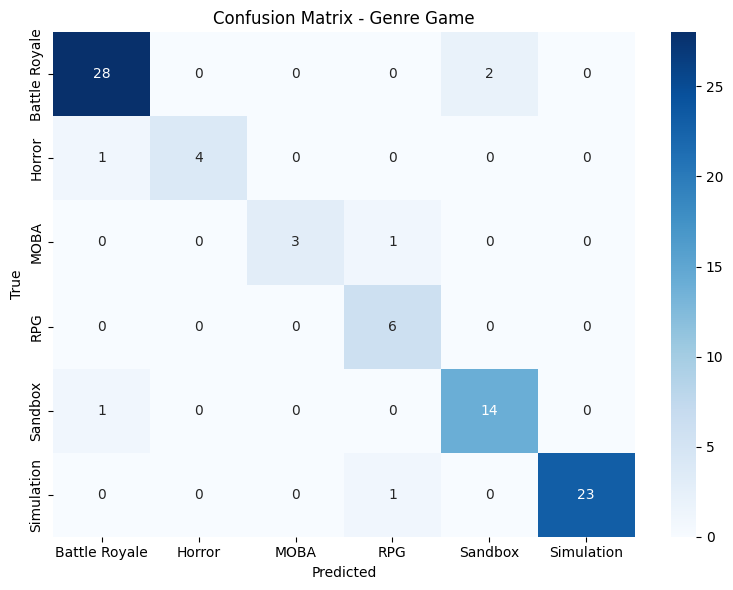

In [13]:
# ====== 9. Confusion Matrix (Opsional) ======
import matplotlib.pyplot as plt
import seaborn as sns

labels = sorted(df_clf["primary_genre"].unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Genre Game")
plt.tight_layout()
plt.show()
